In [111]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger
from tqdm import tqdm

import pickle
import json
import re
from pathlib import Path

data_dir = Path(globals()["_dh"][0]).parent / "data"
figure_dir = data_dir / "figures"
figure_dir.mkdir(exist_ok=True)

plt.style.use("seaborn-bright")
plt.set_cmap("plasma")

<Figure size 432x288 with 0 Axes>

In [152]:
class ThroughputSolver:
    def __init__(self, df_path, default_throughput=0.0):
        self.df = pd.read_csv(df_path).drop(columns="Unnamed: 0").set_index(["src", "dst"])
        self.default_throughput = default_throughput

    def get_path_throughput(self, src, dst):
        if src == dst:
            return self.default_throughput
        elif (src, dst) not in self.df.index:
            return None
        return self.df.loc[(src, dst), "throughput_sent"]

    def get_path_cost(self, src, dst):
        src_provider = src.split(":")[0]
        dst_provider = dst.split(":")[0]
        if src == dst:
            return 0
        elif src_provider == dst_provider:
            return 0.02
        else:
            return 0.09

    def get_regions(self):
        return list(sorted(self.df.index.levels[0].unique()))

    def get_throughput_grid(self):
        regions = self.get_regions()
        data_grid = np.zeros((len(regions), len(regions)))
        for i, src in enumerate(regions):
            for j, dst in enumerate(regions):
                data_grid[i, j] = self.get_path_throughput(src, dst) if self.get_path_throughput(src, dst) is not None else 0
        data_grid = data_grid / 1e9
        return data_grid

    def plot_throughput_grid(self, data_grid, title="Throughput (Gbps)"):
        for i in range(data_grid.shape[0]):
            for j in range(data_grid.shape[1]):
                if i <= j:
                    data_grid[i, j] = np.nan

        regions = self.get_regions()
        fig, ax = plt.subplots(1, 1, figsize=(9, 9))
        ax.imshow(data_grid)
        ax.set_title(title)
        ax.set_xticks(np.arange(len(regions)))
        ax.set_yticks(np.arange(len(regions)))
        ax.set_xticklabels(regions)
        ax.set_yticklabels(regions)

        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

        # compute mean point of non nan values
        mean_point = np.nanmean(data_grid)
        for i, row in enumerate(data_grid):
            for j, col in enumerate(row):
                if i > j:
                    ax.text(j, i, round(col, 1), ha="center", va="center", color="white" if col < mean_point else "black")

        fig.patch.set_facecolor("white")
        fig.subplots_adjust(hspace=0.6)
        ax.figure.colorbar(ax.images[0], ax=ax)
        return fig, ax

    def max_two_hop_throughput(self):
        regions = self.get_regions()
        data_grid = np.zeros((len(regions), len(regions)))
        for i, src in enumerate(regions):
            for j, dst in enumerate(regions):
                data_grid[i, j] = self.get_path_throughput(src, dst) if self.get_path_throughput(src, dst) is not None else 0
                for inter in regions:
                    tp_a = self.get_path_throughput(src, inter) if self.get_path_throughput(src, inter) is not None else 0
                    tp_b = self.get_path_throughput(inter, dst) if self.get_path_throughput(inter, dst) is not None else 0
                    tp = min(tp_a, tp_b)
                    data_grid[i, j] = max(data_grid[i, j], tp)
        data_grid = data_grid / 1e9
        return data_grid

    def max_three_hop_throughput(self):
        regions = self.get_regions()
        data_grid = np.zeros((len(regions), len(regions)))
        for i, src in enumerate(regions):
            for j, dst in enumerate(regions):
                data_grid[i, j] = self.get_path_throughput(src, dst) if self.get_path_throughput(src, dst) is not None else 0
                for inter_a in regions:
                    tp_a = self.get_path_throughput(src, inter_a) if self.get_path_throughput(src, inter_a) is not None else 0
                    for inter_b in regions:
                        tp_b = self.get_path_throughput(inter_a, inter_b) if self.get_path_throughput(inter_a, inter_b) is not None else 0
                        tp_c = self.get_path_throughput(inter_b, dst) if self.get_path_throughput(inter_b, dst) is not None else 0
                        tp = min(tp_a, tp_b, tp_c)
                        data_grid[i, j] = max(data_grid[i, j], tp)
        data_grid = data_grid / 1e9
        return data_grid

    # def solve_optimal_transit(self, src_region, dst_region):
    #     # Create optimization problem with cvxpy
    #     # min cost s.t. achieved_tput >= desired_tput
    #     # constants:
    #     #   max_tput_per_link: max throughput per link in Gbps, continuous vector, size = |src| x |dst|
    #     #   cost_per_gb: cost per GB in $/GB, continuous vector, size = |src| x |dst|
    #     #   gbytes_to_transfer: number of GB to transfer, continuous scalar
    #     # optimization variables:
    #     #   link_active: binary vector, size = |src| x |dst|
    #     #   link_inactive: binary vector, size = |src| x |dst|
    #     #   path_from_src_to_dst: binary vector, size = |src| x |dst|
    #     #   tput_on_link: continuous vector, size = |src| x |dst|
    #     #   achieved_tput: throughput achieved in Gbps, continuous scalar (min of tput_on_link)
    #     #   cost: cost in $, continuous scalar
    #     # constraints:
    #     #   link_inactive = 1 - link_active
    #     #   achieved_tput <= link_inactive[i, j] * 1e3 + max_tput_per_link[i, j]  for all i, j in |src| x |dst|
    #     #   cost = sum_{i,j} [link_active[i, j] * cost_per_gb[i, j] * gbytes_to_transfer]
    #     #   path_from_src_to_dst[src, dst] = 1
    #     #   path_from_src_to_dst[i, j] >= path_active[i, j] for all i, j in |src| x |dst|
    #     #   achieved_tput == 0 if path_from_src_to_dst[src, dst] = 0

    #     regions = self.get_regions()
    #     src_idx = regions.index(src_region)
    #     dst_idx = regions.index(dst_region)

    #     # make constants
    #     max_tput_per_link = np.zeros((len(regions), len(regions)))
    #     # cost_per_gb = np.zeros((len(regions), len(regions)))
    #     for src in regions:
    #         for dst in regions:
    #             tp = self.get_path_throughput(src, dst)
    #             max_tput_per_link[regions.index(src), regions.index(dst)] = tp / 1e9 if tp is not None else 1e9
    #             # cost_per_gb[regions.index(src), regions.index(dst)] = self.get_path_cost(src, dst)

    #     # define key variables
    #     link_active = cp.Variable((len(regions), len(regions)), boolean=True)
    #     path_from_src_to_dst = cp.Variable((len(regions), len(regions)), boolean=True)
    #     achieved_tput = cp.Variable(boolean=False)
    #     tput_on_link = cp.Variable((len(regions), len(regions)), boolean=False)
    #     # cost = cp.sum(link_active * cost_per_gb * gbytes_to_transfer)

    #     # constraints
    #     constraints = []

    #     for i in range(len(regions)):
    #         for j in range(len(regions)):
    #             constraints.append(tput_on_link[i, j] <= (1 - link_active[i, j]) * 1e9 + link_active[i, j] * max_tput_per_link[i, j])
    #             constraints.append(achieved_tput <= tput_on_link[i, j])

    #     constraints.append(path_from_src_to_dst >= link_active)
    #     constraints.append(path_from_src_to_dst[src_idx, dst_idx] >= 1)
    #     constraints.append(achieved_tput <= 1e9 * path_from_src_to_dst[src_idx, dst_idx])

    #     problem = cp.Problem(cp.Maximize(achieved_tput), constraints)
    #     problem.solve()
    #     return problem, (link_active, path_from_src_to_dst, achieved_tput, tput_on_link)


tput = ThroughputSolver(data_dir / "throughput" / "df_throughput_agg.csv")

# regions = tput.get_regions()
# src, dst = regions[0], regions[1]

# problem, variables = tput.solve_optimal_transit(src, dst)
# link_active, path_from_src_to_dst, achieved_tput, tput_on_link = variables

# print(f"Objective: {problem.value}\n")
# for src in tput.get_regions():
#     for dst in tput.get_regions():
#         if link_active[tput.get_regions().index(src), tput.get_regions().index(dst)].value == 1:
#             print(f"Active link: {src} -> {dst}")

# for src in tput.get_regions():
#     for dst in tput.get_regions():
#         if path_from_src_to_dst[tput.get_regions().index(src), tput.get_regions().index(dst)].value == 1:
#             print(f"Path: {src} -> {dst}")

# for row in tput_on_link.value:
#     for col in row:
#         print(f"{col:.2f} ", end="")
#     print()

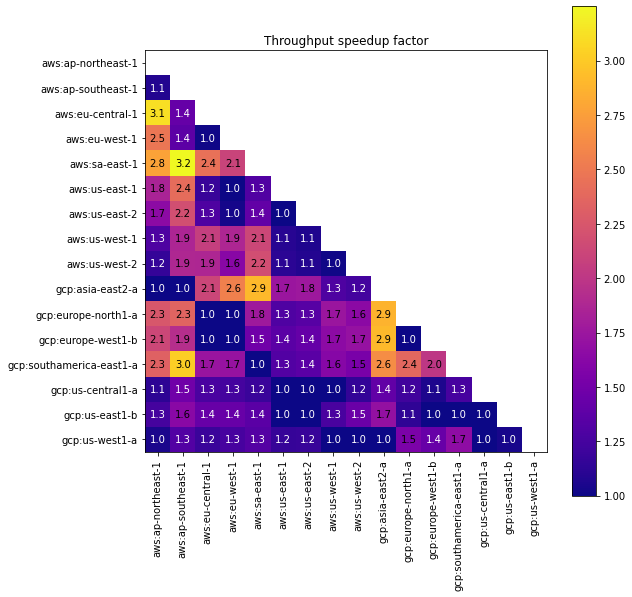

In [153]:
def make_symmetric(mat):
    x, y = mat.shape
    for i in range(x):
        for j in range(y):
            mat[i, j] = max(mat[i, j], mat[j, i])
    return mat


wan = make_symmetric(tput.get_throughput_grid())
one_hop = make_symmetric(tput.max_two_hop_throughput())
for i in range(len(tput.get_regions())):
    wan[i, i] = 1.0
    one_hop[i, i] = 0.0

speedup = one_hop / wan

fig, ax = tput.plot_throughput_grid(speedup, title="Throughput speedup factor")
fig.savefig(str(data_dir / "throughput" / "df_throughput_grid_speedup_1x.png"), bbox_inches="tight", dpi=300)

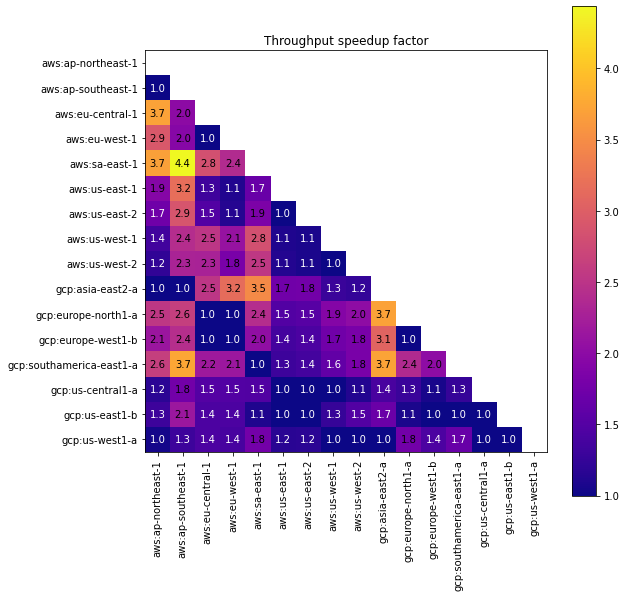

In [154]:
def make_symmetric(mat):
    x, y = mat.shape
    for i in range(x):
        for j in range(y):
            mat[i, j] = max(mat[i, j], mat[j, i])
    return mat


wan = make_symmetric(tput.get_throughput_grid())
one_hop = make_symmetric(tput.max_three_hop_throughput())
for i in range(len(tput.get_regions())):
    wan[i, i] = 1.0
    one_hop[i, i] = 0.0

speedup = one_hop / wan

fig, ax = tput.plot_throughput_grid(speedup, title="Throughput speedup factor")
fig.savefig(str(data_dir / "throughput" / "df_throughput_grid_speedup_2x.png"), bbox_inches="tight", dpi=300)